#### **Imports**

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines import *
from qumcmc.basic_utils import *

#### **Define the Energy Model**

In [2]:
# define the model
np.random.seed(6)# should always be in the same cell!  
n_spins = 12

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
J = J - np.diag(np.diag(J))

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')


                   MODEL : my_model
Non-zero Interactions (J) :  102
Non-zero Bias (h) :  12
---------------------------------------------
Average Interaction Strength :  -0.027777777777777776
Average Bias Strength :  0.25666666666666665
alpha :  0.5779493995278991
model beta :  2.4
---------------------------------------------


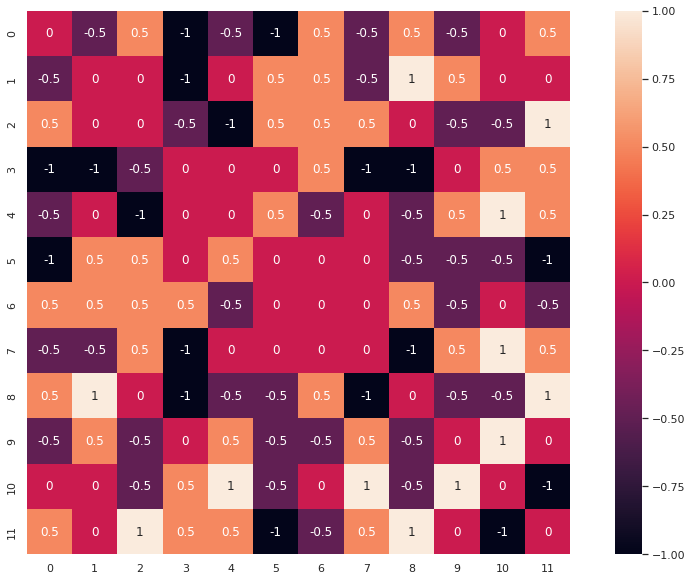

In [8]:
model.model_summary()

#### **Exact Analysis**

In [4]:
## set current beta
beta = 2.4

## run exact sampling over all possible configurations 
model.run_exact_sampling(beta)

Running Exact Sampling | Model beta :  2.4


running over all possible configurations: 100%|██████████| 4096/4096 [00:00<00:00, 9142.78it/s] 

saving distribution to model ...


In [5]:
model.exact_sampling_status

True

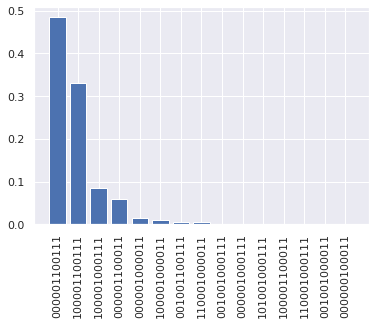

In [6]:
## get the distribution from model
bpd = model.boltzmann_pd

## plot the distribution
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)

#### **Run Classical MCMC**

#### **Run Quantum Enhaned MCMC**

#### **Convergence Analysis**

##### Magnetisation

##### JS Divergence